**Compare the impact "variation" in each parameter and for each iteration (batch) for trainings where the improvement is evident and in cases where the improvement does not occur.<br>**
**Could the improvement could be messured whit p.grad?<br>**
**the variation occurs in the same proportion in all the parameters, there exist patterns?<br>**


# DS

In [15]:
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch.utils.data import DataLoader, Subset, TensorDataset


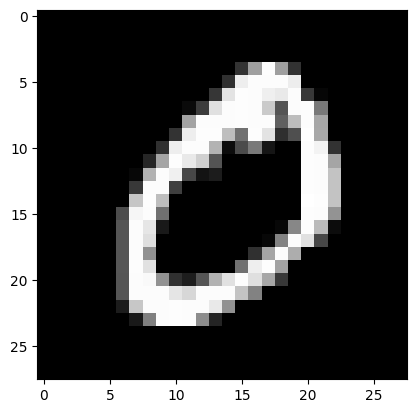

In [110]:
root = './MNIST/'
dataset = torchvision.datasets.MNIST(root = root, train = True, transform = transforms.ToTensor())
x= dataset.__getitem__(1)
plt.imshow(x[0].squeeze(), cmap='gray');

# NN

In [3]:
import torch
import torch.nn.functional as F

In [66]:
class linear:
    def __init__(self, fan_in, fan_out,generator, bias=True, name='linear', ):
        self.name=name
        # self.w = torch.randn(fan_in, fan_out)
        # self.w = torch.randn(fan_in, fan_out)/fan_in**0.5 #from normal distribution
        # self.w = torch.rand(fan_in, fan_out, generator=generator)/fan_in**0.5  #from uniform distribution -> pytorch uses uniform i believe
        self.w = ((2*(torch.rand(fan_in, fan_out, generator=generator)) )-1) /fan_in**0.5 #-> sampled between -1 and 1
        self.bias = torch.randn(fan_out,generator=generator) if bias else None
    def __call__(self, x):
        # print(x.shape)
        self.out = x @ self.w
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.w] + ([] if self.bias is None else [self.bias])
class relu:
    def __init__(self, name='relu'):
        self.name=name
        self.out = None
    def __call__(self,x):
        # self.out =torch.where(x>0, x, 0.0)
        self.out= torch.maximum(x, torch.zeros_like(x))
        return self.out
    def parameters(self):
        return []
class tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
class flatten:   
    def __call__(self, x):
        self.out = x.view(x.size(0), -1) #keep the batch dimension
        # self.out=torch.flatten(x)
        return self.out
    def parameters(self):
        return []
class softmax:
    def __init__(self, beta=1.0):
        self.beta=beta
    def __call__(self, x):
        max = torch.max(x)
        x=x-max
        self.out = torch.exp(x)/torch.sum(torch.exp(x))
        return self.out
    def parameters(self):
        return []

In [80]:
input_size=784
inner_size=128
output_size=64
cat_size=10
generator=torch.Generator().manual_seed(23)
layers = [
    flatten(),
    linear(input_size,inner_size, name='linear_1',generator=generator),
    # relu(name='relu_1'),
    tanh(),
    # linear(inner_size, inner_size,name='linear_2',generator=generator),
    # relu(name='relu_2'),
    # tanh(),
    linear(inner_size, cat_size,name='linear_3',generator=generator)
]
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

In [81]:
def forward(layers, x): 
    # print(x.shape)
    for layer in layers:
        x=layer(x)
        # print(layer.__class__)
        # print(x.shape)

    return x


In [82]:
forward(layers, x[0])

tensor([[ 1.8128, -1.2242,  0.1324, -0.9068,  1.0965, -1.4100,  0.4487, -1.7705,
         -1.1387,  0.2264]], grad_fn=<AddBackward0>)

In [83]:
def nll_loss(y_pred, y, epsilon = 1e-9):
    y_pred = torch.clamp(y_pred, min=epsilon)
    p = y_pred.squeeze()[y]
    # print(f'logmax = {y_pred}')
    # print(f'predicted = {torch.argmax(y_pred)}, ground truth = {y}, probability of ground truth = {p.item()}')
    logp = torch.log(p)
    nlogp=-logp
    # print(f'negative log likelihood : {nlogp.item()}')

    return nlogp


 

In [84]:
from torch.utils.data import random_split
train_size=0.9*len(dataset)
val_size=0.1*len(dataset)
train_dataset, val_dataset = random_split(dataset, [int(train_size),int(val_size) ])

In [87]:
lr = 0.01
iteration = 0
steps=40000
batch_size = 10

loss_steps=500

steps_data = 500

# batching
subset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# histogram
bins=80

n_1=4 -1 
len_1=128

grads_1x=torch.zeros((n_1, int(len(subset_loader)/steps_data)+1, bins)) # (layer n°, data_step, grad)
act_1x=torch.zeros((n_1, int(len(subset_loader)/steps_data)+1, bins))   # (layer n°, data_step, activation)
grads_1y=torch.zeros((n_1, int(len(subset_loader)/steps_data)+1, bins)) # (layer n°, data_step, grad)
act_1y=torch.zeros((n_1, int(len(subset_loader)/steps_data)+1, bins))   # (layer n°, data_step, activation)

# dead neurons
# grad_t_aux=torch.zeros(128,steps)
# out_t_aux=torch.zeros(128,steps)

# grad_t_aux=torch.zeros(128,len(subset_loader))
# out_t_aux=torch.zeros(128,len(subset_loader))
threshold=0.001

# for img, label in train_dataset:
i=0
# for i in range(steps):

out_t =[]
grad_t =[]
out_shapes=[128,128,10]
for lay in range(len(layers)-1):
    
    grad_t_aux=torch.zeros(out_shapes[lay],len(subset_loader))
    out_t_aux=torch.zeros(out_shapes[lay],len(subset_loader))
    out_t.append(out_t_aux)
    grad_t.append(grad_t_aux)


for batch_x, batch_y in subset_loader:

    # print (type(batch_x))
    # print (type(batch_y))

    len_dataset=len(train_dataset)
    index = torch.randint(low=1, high=len_dataset, size=(), generator=generator)

    row=train_dataset.__getitem__(index)
    # out=forward(layers,row[0])
    out=forward(layers,batch_x.squeeze())

    # loss = F.cross_entropy(out.squeeze(),torch.tensor(row[1]))
    loss = F.cross_entropy(out.squeeze(),batch_y)
    
    for layer in layers:
        if not isinstance(layer, flatten):
            layer.out.retain_grad() 
            
    for p in parameters:
        p.grad = None
    loss.backward()
    

    for l in range(len(layers)-1):        
        # store out and grad for the layer
        out_aux=layers[l+1].out
        grad_aux=layers[l+1].out.grad

        # out_t_aux[:,i]=out_1
        # grad_t_aux[:,i] = grad_1
        out_t[l][:,i]=out_aux.mean(dim=0) #mean across the batch dimension
        grad_t[l][:,i] = grad_aux.mean(dim=0) #mean across the batch dimension
       
    #update parameters
    for p in parameters:
        p.data += -lr*p.grad
        
    if i % steps_data == 0:
        # print('saving grads and activations')
        l=0
        for layer in range(len(layers)): 
            print(layers[layer].__class__)
            if isinstance(layers[layer], flatten):
                continue
            hy_act, hx_act = torch.histogram(layers[layer].out,bins, density=True)
            hy_grad, hx_grad = torch.histogram(layers[layer].out.grad,bins, density=True)

            # print(layer,int(i/steps_data), len(hx_grad), type(hx_grad) , grads_1x.shape)

            step = int(i/steps_data)  #the step in the training we are saving data for, ordinality

            grads_1x[l,step,:]=hx_grad[:-1]
            grads_1y[l,step,:]=hy_grad
            act_1x[l,step,:]=hx_act[:-1]
            act_1y[l,step,:]=hy_act
            l+=1
             
    if i % loss_steps == 0:
        with torch.no_grad():
            losses=torch.zeros(loss_steps)
            for j in range(loss_steps):
                index2 = torch.randint(low=1, high=len_dataset, size=())
                row_loss=train_dataset.__getitem__(index2)
                out_loss = out=forward(layers,row_loss[0])
                losses[j] = F.cross_entropy(out_loss.squeeze(),torch.tensor(row_loss[1]))
            print(f'step = {i}, loss = {losses.mean()}')
    i+=1
    # break

<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 0, loss = 2.909446954727173
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 500, loss = 1.0580625534057617
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 1000, loss = 0.637148916721344
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 1500, loss = 0.5011171102523804
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 2000, loss = 0.4770987927913666
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 2500, loss = 0.4363314211368561
<class '__main__.flatten'>
<class '__main__.linear'>
<class '__main__.tanh'>
<class '__main__.linear'>
step = 3000, loss = 0.3833042085170746
<class '__ma

In [88]:
with torch.no_grad():
    for out_l in out_t:
        print(out_l.shape)
        print(out_l.max())
        print(out_l.min())



torch.Size([128, 5400])
tensor(2.3833)
tensor(-2.9175)
torch.Size([128, 5400])
tensor(0.9829)
tensor(-0.9940)
torch.Size([10, 5400])
tensor(4.3315)
tensor(-5.8729)


In [89]:
cos_sim = torch.zeros((len(layers)-1)*2,len(subset_loader))

with torch.no_grad():
    for l in range(len(layers)-1):
        print(l)
        for i in range(out_t[l].size(1)-1):
            cos_sim_aux = F.cosine_similarity(out_t[l][:,i],out_t[l][:,i+1], dim=-1, eps=1e-6)
            cos_sim_aux_2 = F.cosine_similarity(out_t[l][:,0],out_t[l][:,i+1], dim=-1, eps=1e-6)
            cos_sim[l,i]=cos_sim_aux
            cos_sim[l+len(layers)-1,i]=cos_sim_aux_2
print(cos_sim.shape)
    

0
1
2
torch.Size([6, 5400])


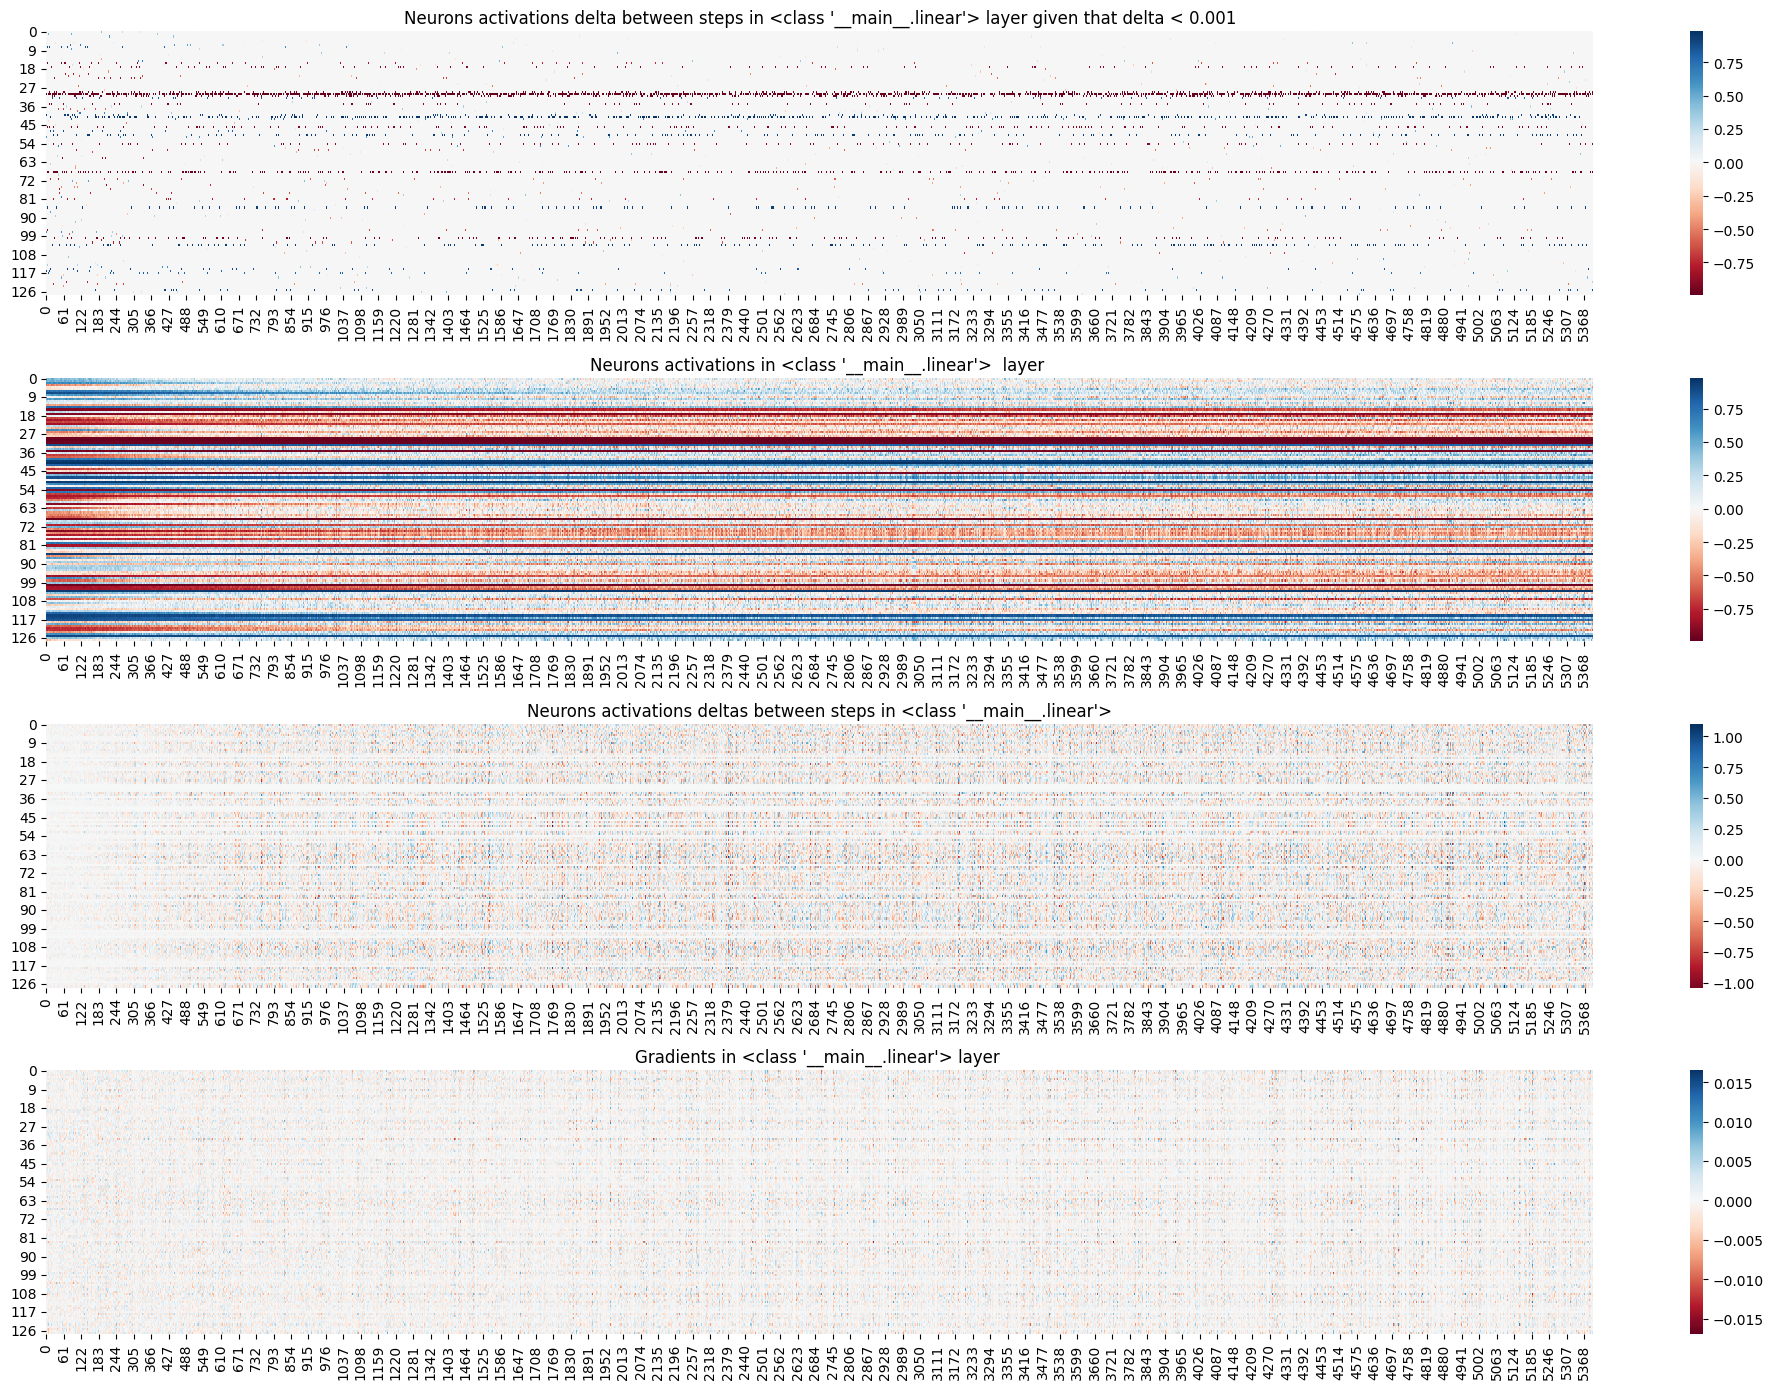

In [90]:
LAYER = 1
threshold=0.001
# Convert the tensor to a NumPy array
# array = out_t_aux.detach().numpy()
# array = out_t.detach().numpy()

array_mask = torch.abs(out_t[LAYER][:,1:].detach() - out_t[LAYER][:,:-1].detach())< threshold
array_mask=torch.cat((array_mask, torch.full((128,1), True)), dim=1)
array = out_t[LAYER].detach()*array_mask.detach()

array2 = out_t[LAYER].detach().numpy()
array3 =out_t[LAYER][:,1:].detach() - out_t[LAYER][:,:-1].detach() #delta between activations for evvery step

# grads 
array4 =grad_t[LAYER].detach().numpy()

# Step 3: Since plotting all 40k columns can be very dense, let's select a subset (optional)
# You can adjust the number of columns to plot
# subset_array = array[:, 30000:31000]  
subset_array = array[:, :]  # every nth column ::n
subset_array2 = array2[:, :]  # every nth column ::n
subset_array3 = array3[:, :]  # every nth column ::n
subset_array4 = array4[:, :]  # every nth column ::n

#------

# Create a figure
fig, ax = plt.subplots(4, 1, figsize=(20, 14))

# Heatmap with Seaborn
sns.heatmap(subset_array, ax=ax[0], cmap='RdBu', center=0)
title = f'Neurons activations delta between steps in {layers[LAYER].__class__} layer given that delta < {threshold}' if LAYER < 7 else 'kernel delta between steps'
ax[0].set_title(title)

sns.heatmap(subset_array2, ax=ax[1], cmap='RdBu', center=0)
title = f'Neurons activations in {layers[LAYER].__class__}  layer ' if LAYER < 7 else 'kernel'
ax[1].set_title(title)

sns.heatmap(subset_array3, ax=ax[2], cmap='RdBu', center=0)
title = f'Neurons activations deltas between steps in {layers[LAYER].__class__}' if LAYER < 7 else 'kernel deltas'
ax[2].set_title(title)

sns.heatmap(subset_array4, ax=ax[3], cmap='RdBu', center=0)
title = f'Gradients in {layers[LAYER].__class__} layer ' if LAYER < 7 else 'kernel gradients'
ax[3].set_title(title)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [109]:
#************************************* COSINE SIMILARITIES ************************************************
# Create a figure
fig5 = go.Figure()
for s in range(cos_sim.size(0)):
    name= f'Layer {s+2}, {layers[s+1].__class__}' if s<3 else f'Layer {s-1}, vs first step'
    fig5.add_trace(go.Scatter(
        y=(cos_sim[s]).numpy(),  # Convert each row (tensor) to numpy for plotting
        mode='lines',
        name=name,  # Label each series differently
        line=dict(width=1)  # You can customize color/width here
    ))
# Customize the layout
fig5.update_layout(
    title="Cosine variations between stpes in the activations for each layer",
    xaxis_title="Column Index",
    yaxis_title="Cosine Similarity",
    showlegend=True,
    template="plotly",
    height=500,
    width=1600
)
fig5.show()

In [92]:
n_layers,steps, bins = grads_1x.shape
n_layers, steps, bins

(3, 11, 80)

In [98]:
#from 1 to len(layers)-1 = 3 given the flatten layer (layer 0) has not activations or grad stored

fig = make_subplots(rows=3, cols=1, subplot_titles=[f'Layer {i}, {layers[i+1].__class__}' for i in range(3)])
for i in range(n_layers):
    histo_x= act_1x[i,:,:]  
    histo_y= act_1y[i,:,:]  
    k= 1
    for hx, hy in zip(histo_x,histo_y):
        spin = k*steps_data
        fig.add_trace(go.Scatter(x=hx[:-1].detach(), y=hy.detach(), mode='lines', name=spin), row=i+1, col=1)
        k+=1
fig.update_layout(height=1300, width=1300, title_text="Layers activations vs training step")

fig.show()

In [99]:
#from 1 to len(layers)-1 = 3 given the flatten layer (layer 0) has not activations or grad stored

fig = make_subplots(rows=3, cols=1, subplot_titles=[f'Layer {i}, {layers[i+1].__class__}' for i in range(3)])
for i in range(n_layers):
    histo_grad_x= grads_1x[i,:,:]   
    histo_grad_y= grads_1y[i,:,:]   
    k= 1
    for hx, hy in zip(histo_grad_x,histo_grad_y):
        spin = k*steps_data
        fig.add_trace(go.Scatter(x=hx[:-1].detach(), y=hy.detach(), mode='lines', name=spin), row=i+1, col=1)
        k+=1
fig.update_layout(height=1300, width=1300, title_text="Layers gradients vs training step")

fig.show()